For this visualization to happen we will

1. Transform the dataset into the two principal components using PCA
2. Perform LDA on the two components and draw the decision bounds

In [18]:
import numpy as np
import pandas as pd

# Styling for the plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Import custom data cleaning module
import sys 
sys.path.append('../src')
import data_cleaning

np.random.seed(42)

# Wine Dataset

### Step 1: Read the data and clean it

In [19]:
# Load the wine dataset and clean it
file_path   = '../data/wine/winequality-red.csv'
raw_data    = pd.read_csv(file_path, delimiter=';')
clean_data  = data_cleaning.get_clean_data(raw_data, verbose=False)
clean_data  = data_cleaning.compute_y_column_wine(clean_data)

# Split between X and y and create the numpy arrays
x_vars = clean_data.columns.tolist()
y_var  = 'y' 
x_vars.remove(y_var)

#--------------------------------------------------------------------------
# Train test split
#--------------------------------------------------------------------------
X_train,X_test,y_train, y_test = data_cleaning.train_test_split(
        clean_data,
        x_vars,
        y_var)

X_train.shape

(1100, 11)

### Step 1: perform PCA on the training set

In [20]:
def fit_pca(X):
    """
    Two components only
    """
    mu     = np.mean(X, axis=0) # mean for each column
    X_cent = X - mu     # subtract the mean
    sigma  = X_cent.T.dot(X_cent)/(X.shape[0]-1) # covariance matrix
    eig_values, eig_vectors = np.linalg.eig(sigma) # eigeinvalues and corresponding eigenvectors
    
    # Sort the eigenvalues by descending order
    eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:,i]) for i in range(len(eig_values))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)

    # Build the projection matrix from the first top 2 eigenvectors
    W = np.c_[eig_pairs[0][1], eig_pairs[1][1]]
    # Project the original X matrix onto the new subspace
    return X.dot(W)
   

X_proj = fit_pca(X_train)
X_proj.shape

(1100, 2)

**Plot the new dataset**

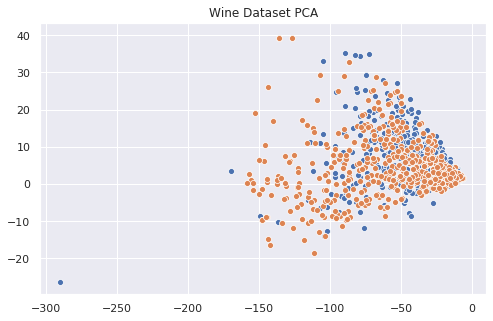

In [26]:
def plot_data(X, y, title):
    
    fig = plt.figure(figsize=(8,5))
    pos = []
    neg = []

    for i in range(X.shape[0]):
        if y[i] == 1:
            pos.append((X[i,0], X[i,1])) # Positive class
        else:
            neg.append((X[i,0], X[i,1])) # Negative class

    # Convert the lists of tupples into numpy arrays for visualization
    pos = np.array(pos, dtype='float')
    neg = np.array(neg, dtype='float')

    sns.scatterplot(x=pos[:,0], y=pos[:,1])
    sns.scatterplot(x=neg[:,0], y=neg[:,1])
    plt.title(title)

plot_data(X_proj, y_train, "Wine Dataset PCA")

### Step 2: Display LDA predictions and decision boundary

In [81]:
def plot_predictions_results(model, X_test, y_test, title):
    """
    plots the predictions of our custom classifier versus
    the ones from the sklean library, as well as the actual
    y values
    """
    fig  = plt.figure(figsize=(12,8))
    tp, tn, fp, fn = [], [], [], []

    # For this plot we need the model predictions on X_test projected onto the
    # PCA subspace
    X_proj = fit_pca(X_test)
    pred = model.predict(X_proj)
    
    for i in range(X_proj.shape[0]):
        if y_test[i] == 1:
            # Positive class
            if pred[i] == 1:
                tp.append((X_proj[i,0], X_proj[i,1])) # True positive
            else:
                fn.append((X_proj[i,0], X_proj[i,1])) # False negative
        else:
            # Negative class
            if pred[i] == 1:
                fp.append((X_proj[i,0], X_proj[i,1])) # False positive
            else:
                tn.append((X_proj[i,0], X_proj[i,1])) # True negative

    # Convert the lists of tupples into numpy arrays for visualization
    tp = np.array(tp, dtype='float')
    tn = np.array(tn, dtype='float')
    fp = np.array(fp, dtype='float')
    fn = np.array(fn, dtype='float')
    
    sns.scatterplot(x=tp[:,0], y=tp[:,1])
    sns.scatterplot(x=fp[:,0], y=fp[:,1])
    sns.scatterplot(x=tn[:,0], y=tn[:,1])
    sns.scatterplot(x=fn[:,0], y=fn[:,1])
    
    # Show probability threshold area
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, alpha=0.4)

    fig.legend(labels=['True Positives', 'False Positives', 'True Negatives', 'False Negatives'], loc='upper left')
    plt.title(title)



### Sklean LDA

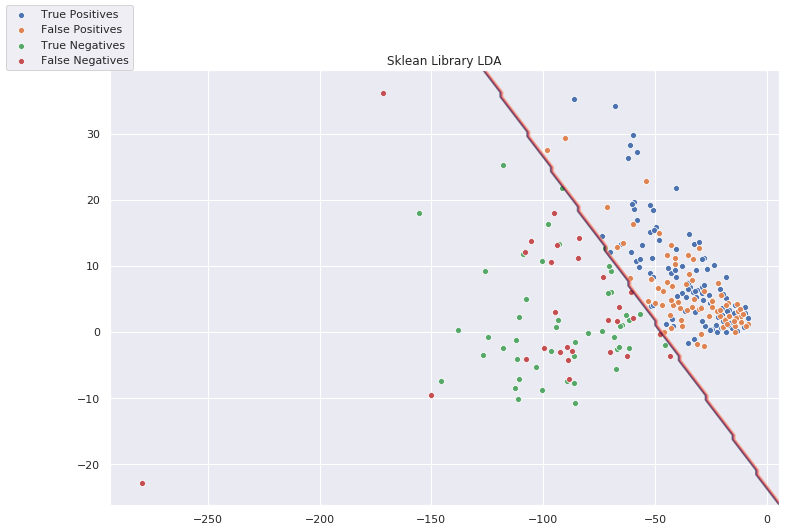

In [85]:
# Sklearn LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as Sklean_LDA
sklearn_lda = Sklean_LDA()

# This time we are fitting the training data projected onto the subspace from PCA
sklearn_lda.fit(X_proj, y_train)

plot_predictions_results(sklearn_lda, X_test, y_test, 'Sklean Library LDA')

### Our own LDA

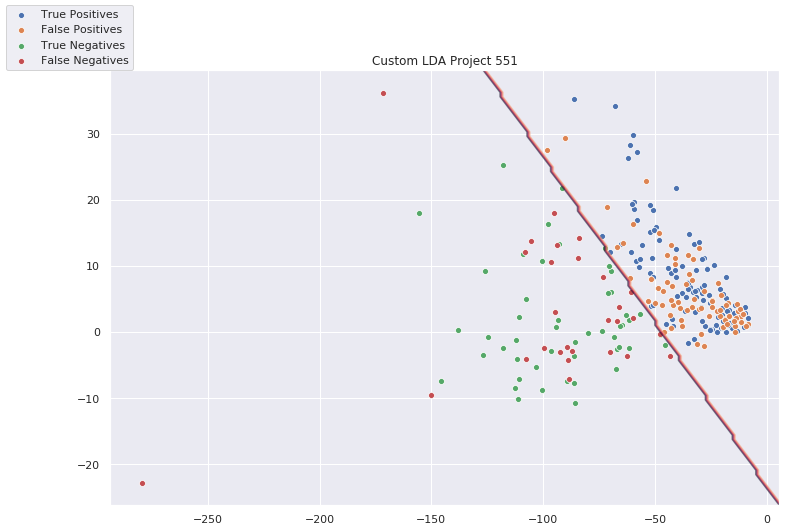

In [86]:
# Custom LDA
import LDA as Custom_LDA

# This time we are fitting the training data projected onto the subspace from PCA
custom_lda = Custom_LDA.LDA(X_proj, y_train)
custom_lda.fit(X_proj, y_train)

plot_predictions_results(custom_lda, X_test, y_test, 'Custom LDA Project 551')